<a href="https://colab.research.google.com/github/jh9553-commits/Bonus-Time-Series/blob/main/Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating synthetic dataset...
Dataset shape: (500, 30), Labels: [236 264]
Train shape: (300, 30) | Val shape: (100, 30) | Test shape: (100, 30)
After normalization:
Train: (300, 30) | Val: (100, 30) | Test: (100, 30)
Train mean: 0.000000, std: 1.000000
Val mean: -0.016727, std: 0.986320

Using device: cpu

Starting training...
Epoch [10/50] Loss: 0.3367 | Val Acc: 0.8300
Epoch [20/50] Loss: 0.3105 | Val Acc: 0.8300
Epoch [30/50] Loss: 0.3252 | Val Acc: 0.8300
Epoch [40/50] Loss: 0.3131 | Val Acc: 0.8300
Epoch [50/50] Loss: 0.3050 | Val Acc: 0.8300

✓ Test Accuracy: 0.9000
✓ Training plots saved to 'training_history.png'

Sample Predictions:
Sample 0: Predicted=Uptrend, True=Uptrend ✓
Sample 10: Predicted=Uptrend, True=Uptrend ✓
Sample 20: Predicted=Downtrend, True=Downtrend ✓


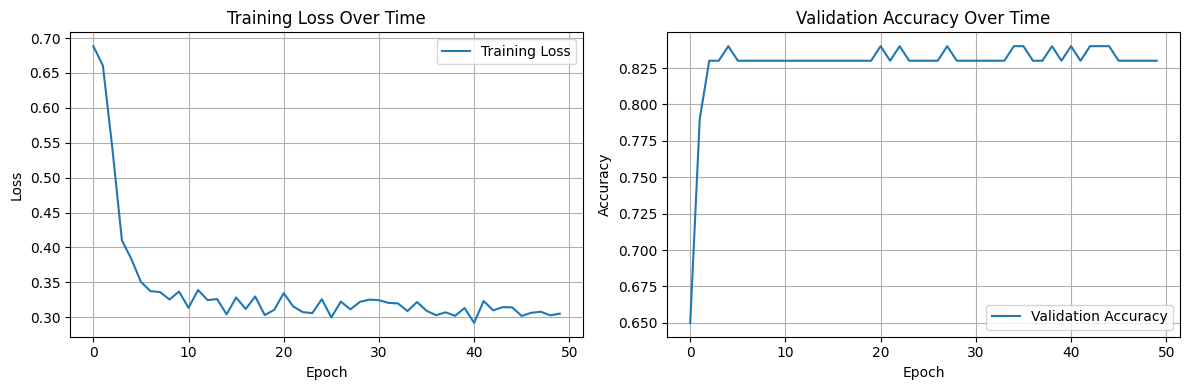

In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# Part 1: Data Preparation for Time Series
# ============================================================================

def create_synthetic_timeseries(n_samples=1000, sequence_length=30):
    """
    Generate synthetic time series data with trend and seasonality.
    Labels: 0 = downtrend, 1 = uptrend
    """
    np.random.seed(42)
    X = []
    y = []

    for _ in range(n_samples):
        # Trend component
        trend = np.linspace(0, np.random.uniform(-2, 2), sequence_length)
        # Seasonality component
        seasonality = 2 * np.sin(np.linspace(0, 4*np.pi, sequence_length))
        # Noise
        noise = np.random.normal(0, 0.5, sequence_length)

        series = trend + seasonality + noise
        X.append(series)

        # Label based on overall trend
        y.append(1 if series[-1] > series[0] else 0)

    return np.array(X), np.array(y)

# Generate data
print("Generating synthetic dataset...")
X, y = create_synthetic_timeseries(n_samples=500, sequence_length=30)
print(f"Dataset shape: {X.shape}, Labels: {np.bincount(y)}")

# Split into train/val/test
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Train shape: {X_train.shape} | Val shape: {X_val.shape} | Test shape: {X_test.shape}")

# ============================================================================
# IMPORTANT: Normalize correctly (FIX)
# ============================================================================
# NOTE: StandardScaler expects (n_samples, n_features)
# Our X has shape (n_samples, sequence_length)
# Each sequence of 30 timesteps = 30 features

scaler = StandardScaler()

# FIT ONLY on training data, then transform all sets with the SAME scaler
X_train = scaler.fit_transform(X_train)      # Fit & transform train
X_val = scaler.transform(X_val)              # Transform val with train's scaler
X_test = scaler.transform(X_test)            # Transform test with train's scaler

print(f"After normalization:")
print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")
print(f"Train mean: {X_train.mean():.6f}, std: {X_train.std():.6f}")
print(f"Val mean: {X_val.mean():.6f}, std: {X_val.std():.6f}")

# ============================================================================
# Part 2: Build Time Series Classifier with PyTorch
# ============================================================================

class TimeSeriesLSTM(torch.nn.Module):
    """
    LSTM-based model for time series classification.
    Takes sequence of values and predicts trend direction (up/down).
    """
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3):
        super(TimeSeriesLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        # Dense layers
        self.fc1 = torch.nn.Linear(hidden_size, 32)
        self.fc2 = torch.nn.Linear(32, 2)  # Binary classification
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        # Reshape for LSTM: (batch_size, sequence_length, 1)
        x = x.unsqueeze(-1)

        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use last hidden state
        last_hidden = lstm_out[:, -1, :]

        # Fully connected layers
        out = self.relu(self.fc1(last_hidden))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

# ============================================================================
# Part 3: Training Loop
# ============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Initialize model
model = TimeSeriesLSTM(input_size=1, hidden_size=64, num_layers=2)
model = model.to(device)

# Training configuration
learning_rate = 0.001
num_epochs = 50
batch_size = 32
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Training
train_losses = []
val_accuracies = []

print("\nStarting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0

    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(X_train_tensor) // batch_size + 1)
    train_losses.append(avg_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
        val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

# ============================================================================
# Part 4: Evaluation & Visualization
# ============================================================================

# Test evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = (test_preds == y_test_tensor).float().mean().item()

print(f"\n✓ Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=100, bbox_inches='tight')
print("✓ Training plots saved to 'training_history.png'")

# Sample predictions
print("\nSample Predictions:")
test_preds_cpu = test_preds.cpu().numpy()
sample_indices = [0, 10, 20]
for idx in sample_indices:
    pred = test_preds_cpu[idx]
    true = y_test[idx]
    pred_label = "Uptrend" if pred == 1 else "Downtrend"
    true_label = "Uptrend" if true == 1 else "Downtrend"
    match = "✓" if pred == true else "✗"
    print(f"Sample {idx}: Predicted={pred_label}, True={true_label} {match}")